# Monte Carlo Control

In [63]:
import sys
import random
import gym
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy

In [64]:
env = gym.make('Blackjack-v1')
env_weighted = gym.make('Blackjack-v1')

In [65]:
def get_probs(Q_s, epsilon, nA):
    """ 
    Get the probability of taking the best known action according to epsilon.
    Returns the policy for the Q value given
    """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [66]:
def best_policy(Q):
    """
    returns the best actions for each Q value in the policy
    """
    return dict((k,np.argmax(v)) for k, v in Q.items())

In [67]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

def create_random_policy(nA): # Policy that returns a random action, all equally likely
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [68]:
def update_Q(episode, Q, alpha, gamma):
    """
    Calculate the new Q values for the actions taken in the given episode.
    Returns the new Q policy
    """    
    for s, a, r in episode:
        first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])
    
    return Q

In [69]:
def play_game(env, Q, epsilon, nA):
    """ 
    generates an episode from following the epsilon-greedy policy containing the state, action and reward for 
    each time step in the episode.
    Returns all step information for that episode
    """
    episode = []
    state = env.reset()
    while True:
        if type(state[0]) == tuple:
            state = state[0]
        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) if state in Q else env.action_space.sample()
        next_state, reward, done, _,info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [70]:
def mc_control(env, num_episodes):
    """
    main method. Iterates through episodes updating epsilon after each, retrieves the list of states, actions
    and rewards from the last episode and use them to calculate the updated Q values
    """
    epsilon = 1.0
    eps_min = 0.01
    decay = 0.9999
    alpha = 0.001
    gamma = 1.0
    
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        epsilon = max(epsilon*decay, eps_min)
        episode = play_game(env, Q, epsilon, nA)
        Q = update_Q(episode, Q, alpha, gamma)
    
    policy = best_policy(Q)
    return policy, Q

In [71]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
        
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, trunc, terminated = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            if type(state[0]) == tuple:
                state = state[0]
            # Update the total reward since step t
            G = discount_factor * G + reward
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula (5.7)
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the behavior policy is not the action 
            # taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./behavior_policy(state)[action]
        
    return target_policy, Q

Episode 1000/500000.

/home/theojeannes/Dev/Scolaire/AppParRenforcement/python/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 500000/500000.

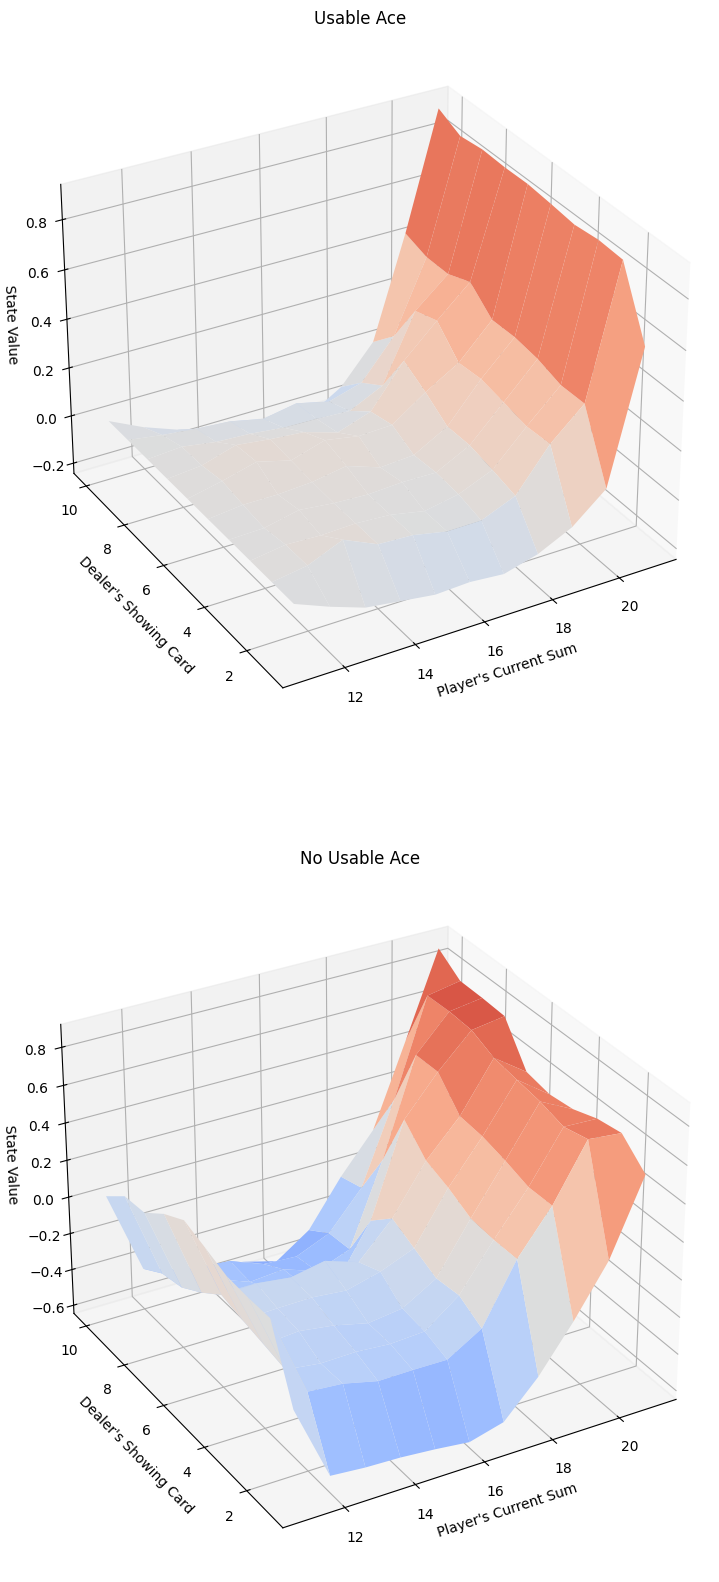

In [72]:
policy, Q = mc_control(env, 500000)
V = dict((k,np.max(v)) for k, v in Q.items())
plot_blackjack_values(V)

Episode 500000/500000.

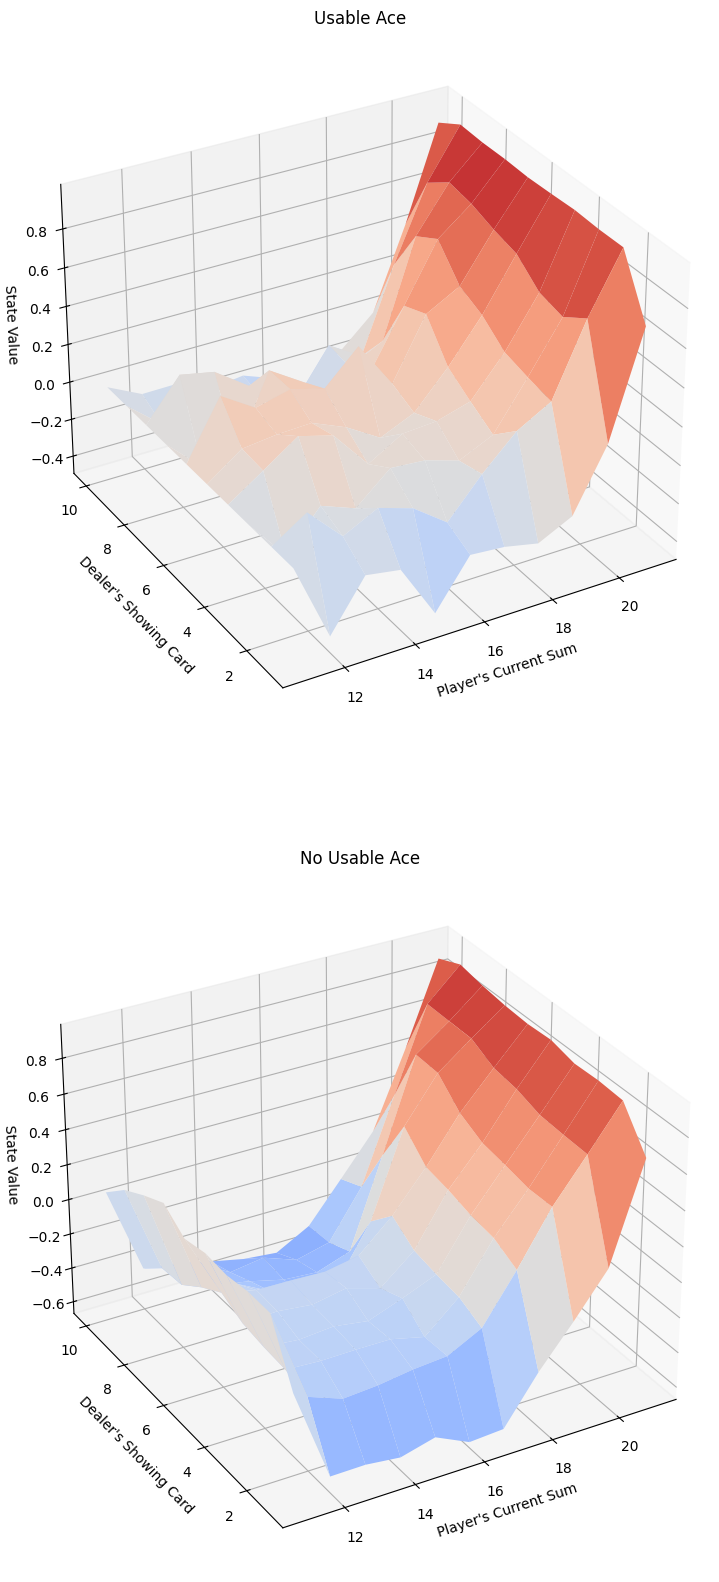

In [73]:
random_policy = create_random_policy(env.action_space.n)
policy_weighted, Q_weighted = mc_control_importance_sampling(env_weighted, 500000, random_policy)
V_weigthed = dict((k,np.max(v)) for k, v in Q_weighted.items())
plot_blackjack_values(V_weigthed)